In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")

In [2]:
from methods import lc_extrapolation, pfn
from tasks import toy_priors
import numpy as np
import pandas as pd
import torch

import json
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba

%matplotlib inline

In [3]:
rng = np.random.RandomState(seed=3)
with open("../data/lc.npy", "rb") as f:
    X = np.load(f)

(0.0, 1.0)

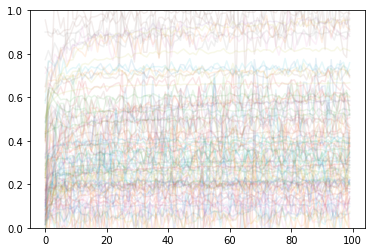

In [4]:
for y in X:
    plt.plot(y, alpha=0.1)
plt.ylim(0, 1)

In [64]:
def get_data():
    return pd.read_csv("../data/data_clean_results.csv")

In [65]:
df = get_data()

In [66]:
df.head()

,t,y_pred,y,model,config_id,cutoff,nsamples,ll,fit_time,predict_time
0,71,0.142822,0.128428,lc_extrapolation,93,70,520,2.775407,92.415781,19.613444
1,72,0.142892,0.143868,lc_extrapolation,93,70,520,3.315020,92.415781,19.613444
2,73,0.142961,0.141778,lc_extrapolation,93,70,520,3.308963,92.415781,19.613444
3,74,0.143028,0.123812,lc_extrapolation,93,70,520,2.376096,92.415781,19.613444
4,75,0.143095,0.142473,lc_extrapolation,93,70,520,3.312171,92.415781,19.613444


In [67]:
df[df.model != "lc_extrapolation"].loc[:, 'nsamples'] = 4500 # hack seaborn

/tmp/slurm_15772400/ipykernel_1681020/588017664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.model != "lc_extrapolation"].loc[:, 'nsamples'] = 4500 # hack seaborn


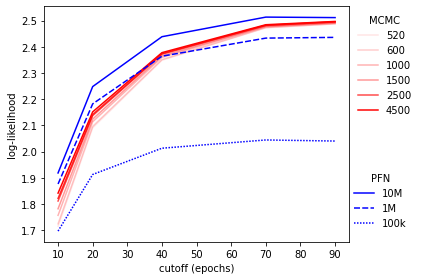

In [68]:
fig, ax = plt.subplots()

color_dict = {
    4500: to_rgba("red", 1), 
    3000: to_rgba("red", 0.8), 
    2500: to_rgba("red", 0.7),
    1500: to_rgba("red", 0.4),
    1000: to_rgba("red", 0.3),
    600: to_rgba("red", 0.2),
    520: to_rgba("red", 0.1)
}

sns.lineplot(data=df[df.model == "lc_extrapolation"].groupby(["model", "cutoff", "nsamples"])["ll"].mean().reset_index(), 
             x="cutoff", y="ll", hue="nsamples", style_order=[4500, 3000, 2500, 1500, 1000, 600, 520], ax=ax, palette=color_dict)
sns.lineplot(data=df[df.model != "lc_extrapolation"].groupby(["model", "cutoff", "nsamples"])["ll"].mean().reset_index(), 
             x="cutoff", y="ll", style="model", ax=ax, color="blue", style_order=["pfn1000", "pfn100", "pfn10"])


handlers, labels = ax.get_legend_handles_labels()

ax.set_ylabel("log-likelihood")
ax.set_xlabel("cutoff (epochs)")

lines = ax.get_lines()
legend1 = plt.legend(lines[:5] + [lines[6]], [520, 600, 1000, 1500, 2500, 4500], frameon=False, title="MCMC", bbox_to_anchor=(1, 1))
legend2 = plt.legend(lines[-6:], ["10M", "1M", "100k"], frameon=False, title="PFN", loc='lower right', bbox_to_anchor=(1.22, 0.02))
ax.add_artist(legend1)
#ax.add_artist(legend2)

fig.tight_layout()
fig.savefig("models_log_likelihood.png")

In [69]:
df_lc = df[df.model == "lc_extrapolation"]

In [70]:
df_lc["runtime"] = df_lc.fit_time.values + df_lc.predict_time.values

/tmp/slurm_15772400/ipykernel_1681020/3820452805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc["runtime"] = df_lc.fit_time.values + df_lc.predict_time.values


In [71]:
sdf_lc = df_lc.drop(["y_pred", "y", "model", "nsamples", "fit_time", "predict_time", "t"], axis=1)
sdf_lc = sdf_lc.groupby(["config_id", "cutoff", "runtime"])["ll"].mean().reset_index()

In [72]:
sdf_lc.groupby(["config_id", "cutoff"]).apply(lambda x: x.runtime.min()).max()

149.61196899414062

In [73]:
def cum_ll_time(_df):
    idx = np.arange(150, 800, 20)
    lls = [_df[_df.runtime < t].iloc[-1].ll for t in idx]
    return pd.DataFrame({
        "runtime": idx,
        "lls": lls
    })

In [74]:
df_cum = sdf_lc.groupby(["config_id", "cutoff"]).apply(cum_ll_time)

In [75]:
df_cum = df_cum.reset_index()

In [76]:
df_pfn = df[df.model == "pfn1000"]
df_pfn["runtime"] = df_pfn.fit_time.values + df_pfn.predict_time.values

/tmp/slurm_15772400/ipykernel_1681020/1107962474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pfn["runtime"] = df_pfn.fit_time.values + df_pfn.predict_time.values


In [77]:
sdf_pfn = df_pfn.drop(["y_pred", "y", "model", "nsamples", "fit_time", "predict_time", "t"], axis=1)
sdf_pfn = sdf_pfn.groupby(["config_id", "cutoff", "runtime"])["ll"].mean().reset_index()

In [78]:
pfn = sdf_pfn[sdf_pfn.cutoff == 10]

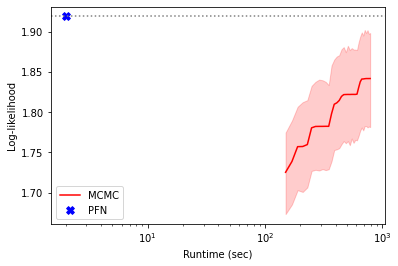

In [79]:
fig, ax = plt.subplots()
sns.lineplot(data=df_cum[df_cum.cutoff == 10], x="runtime", y="lls", ax=ax, color="red")
sc = ax.scatter(x=[2], 
           y=[pfn.ll.mean()], label="PFN", color="blue", s=[60], marker="X")
ax.set_xscale("log")
ax.axhline(y=pfn.ll.mean(), color="gray", linestyle="dotted")
lines = ax.get_lines()
ax.legend([lines[0], sc], ["MCMC", "PFN"], frameon=True, loc=3)
ax.set_xlabel("Runtime (sec)")
ax.set_ylabel("Log-likelihood")
fig.savefig("runtime.png")

In [80]:
df.loc[df.model == "lc_extrapolation", "model"] = df[df.model == "lc_extrapolation"].nsamples.apply(lambda x: "MCMC_" + str(x))

In [81]:
map_name = {
    "MCMC_520": "\\mcmc{520}",
    "MCMC_600": "\\mcmc{600}",
    "MCMC_1000": "\\mcmc{1000}",
    "MCMC_1500": "\\mcmc{1500}",
    "MCMC_2500": "\\mcmc{2500}",
    "MCMC_3000": "\\mcmc{3000}",
    "MCMC_4500": "\\mcmc{4500}",
    "pfn10": "\\pfn{100k}",
    "pfn100": "\\pfn{1M}",
    "pfn1000": "\\pfn{10M}",
}

In [82]:
df["inference_time"] = df["fit_time"] + df["predict_time"]
df_g = df.groupby(["model", "cutoff", "config_id"])

MSE = df_g[["y_pred", "y"]].apply(lambda x: ((x.y_pred - x.y).values**2).mean()).reset_index().reset_index().groupby(["model", "cutoff"])[0]

TIME = df_g[["inference_time"]].first().reset_index().groupby(["model", "cutoff"])[["inference_time"]]
LL = df_g["ll"].mean().reset_index().groupby(["model", "cutoff"])["ll"]
for model in ['MCMC_520', 'MCMC_600', 'MCMC_1000', 'MCMC_1500', 'MCMC_2500',
       'MCMC_3000', 'MCMC_4500', "pfn10", "pfn100", "pfn1000"]:
    res_cutoff = " & ".join(["{:.2} $\\pm$ {:.2}  & {:.2} $\\pm$ {:.2}".format(
                                                                                LL.mean().loc[model, cutoff], 
                                                                                LL.std().loc[model, cutoff],
    TIME.mean().loc[model, cutoff].inference_time, 
        TIME.std().loc[model, cutoff].inference_time,) 
 for cutoff in [10, 20, 40, 70, 90]])
    print("{:17} & {} \\\\".format(
        map_name[model],
        res_cutoff
    ))

\mcmc{520}        & 1.7 $\pm$ 0.85  & 1e+02 $\pm$ 2.2e+01 & 2.1 $\pm$ 0.99  & 1.1e+02 $\pm$ 2.2e+01 & 2.3 $\pm$ 0.91  & 1.1e+02 $\pm$ 2.7e+01 & 2.5 $\pm$ 0.93  & 1.1e+02 $\pm$ 2.8e+01 & 2.5 $\pm$ 0.95  & 1.1e+02 $\pm$ 2.8e+01 \\
\mcmc{600}        & 1.7 $\pm$ 0.85  & 1.1e+02 $\pm$ 2.5e+01 & 2.1 $\pm$ 0.99  & 1.2e+02 $\pm$ 2.5e+01 & 2.4 $\pm$ 0.91  & 1.2e+02 $\pm$ 3e+01 & 2.5 $\pm$ 0.93  & 1.2e+02 $\pm$ 3.1e+01 & 2.5 $\pm$ 0.96  & 1.2e+02 $\pm$ 3.2e+01 \\
\mcmc{1000}       & 1.8 $\pm$ 0.86  & 1.6e+02 $\pm$ 3.7e+01 & 2.1 $\pm$ 0.98  & 1.7e+02 $\pm$ 3.7e+01 & 2.4 $\pm$ 0.92  & 1.7e+02 $\pm$ 4.5e+01 & 2.5 $\pm$ 0.93  & 1.8e+02 $\pm$ 4.8e+01 & 2.5 $\pm$ 0.96  & 1.8e+02 $\pm$ 4.8e+01 \\
\mcmc{1500}       & 1.8 $\pm$ 0.89  & 2.3e+02 $\pm$ 5.3e+01 & 2.1 $\pm$ 1.0  & 2.4e+02 $\pm$ 5.3e+01 & 2.4 $\pm$ 0.92  & 2.4e+02 $\pm$ 6.3e+01 & 2.5 $\pm$ 0.93  & 2.5e+02 $\pm$ 6.7e+01 & 2.5 $\pm$ 0.96  & 2.5e+02 $\pm$ 6.8e+01 \\
\mcmc{2500}       & 1.8 $\pm$ 0.91  & 3.5e+02 $\pm$ 8.3e+01 & 2.1 $\pm$ 1.0  & 3.